## Import Libraries and Frameworks

In [1]:
import numpy as np
import pandas as pd
import sys
import datetime
import pickle
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from textblob import TextBlob
from spacytextblob.spacytextblob import SpacyTextBlob

import lightgbm as lgb

In [2]:
lgb.LGBMClassifier

lightgbm.sklearn.LGBMClassifier

We'll use en_core_web_sm.

In [3]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

Use pickle to load the preprocessed data from `datacleaning.ipynb`

In [5]:
with open('../data/processed-3.pickle', 'rb') as handle:
    dictionary = pickle.load(handle)

## The Flow of Birdwatch

* Birdwatcher (data laborer for twitter) goes into the Birdwatch interface
* Write a note, which others can immediately see (?)
* Other Birdwatchers who see the note can rate the note along a BUNCH of axes.


## How and Why to Predict?

1. Given the text of a NOTE, how likely is that NOTE to be rated as HELPFUL (i.e. receive a helpfulness score above twitter's threshold)
    - Data pre-preprocessing should aim to give us something like: featurized text | helpfulness label
    - We lemmaize, tokenize, remove links and punctuation, and send all words to lowercase, and vectorize text content
    - We also calculate a tweet's polarity and subjectivity. 
2. Given the text of a tweet, how likely is that Tweet to be flagged by Birdwatchers.
    - Also do featuriztion of tweets
3. Given the time that a note is given, is there some way to weight more recent notes and give it more importance

## Prediction Functions

In [ ]:
def fit_model(X, y, y_col, model):
    clf = model(random_state=0).fit(X, y[y_col])
    return clf

In [ ]:
def model(mod, model_name, x_train, y_train, x_test, y_test):
    mod.fit(x_train, y_train)
    print(model_name)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 5)
    predictions = cross_val_predict(mod, X_train, y_train, cv = 5)
    print("Accuracy:", round(acc.mean(),3))
    cm = confusion_matrix(predictions, y_train)
    print("Confusion Matrix:  \n", cm)
    print("                    Classification Report \n",classification_report(predictions, y_train))

In [ ]:
def concat_word_vec_and_metadata(df, arr):
    metadata = X[['has_links', 'word_count', 'polarity', 'subjectivity']].to_numpy()

    return np.concatenate(
        [word_vecs, metadata],
        axis=1
    )

In [ ]:
metadata_cols = ['has_links', 'word_count', 'polarity', 'subjectivity']

In [ ]:
def preprocess(df, trn_mask, df_type='notes_with_ratings'):
    """
    Take in the notes or tweets data as provided by twitter and output
    a "ready for ML" version.

    Args - meant to match the output of the consolidate_files() function
        df - either a notes_with_ratings df or tweets_with_notes df
        text_col - name of the column with cleaned text
        df_type - 'notes_with_ratings' or 'tweets_with_notes'
        trn_mask - boolean array ("mask") that indicates which rows are used for training

    Output
        Dictionary with train and test sets
    """
    if df_type == 'notes_with_ratings':
        text_col = 'clean_summary_as_str'
    else:
        text_col = 'clean_text_as_str'
    # Run spaCy pre-processing
    docs = nlp.pipe(df[text_col])
    # Turn into numpyp array
    X_vector = np.array([x.vector for x in docs])
    # concatenate metadata to a single "X as matrix"
    X_mat = np.concatenate(
        [X_vector, df[metadata_cols].to_numpy()],
        axis=1
    )

    if df_type == 'notes_with_ratings':
        df.loc[:, 'is_helpful'] = df['helpful'] == 2
        y_df = df[['is_helpful']]
    else:
        y_df = df[['classification', 'believable', 'harmful', 'validationDifficulty']]

        cleanup = {
            "classification": {
                "MISINFORMED_OR_POTENTIALLY_MISLEADING": 1, "NOT_MISLEADING": 0
                },
            "believable": {"BELIEVABLE_BY_MANY": 1, "BELIEVABLE_BY_FEW": 0},
            "harmful": {"CONSIDERABLE_HARM": 1, "LITTLE_HARM": 0},
            "validationDifficulty": {"EASY": 0, "CHALLENGING": 1}
        }
        y_df = y_df.astype(str).replace(cleanup)

    if len(X_mat) != len(y_df):
        print(len(X_mat), "   ", len(y_df))
        raise Exception("length is not equal")

    X_trn = X_mat[trn_mask, :]
    X_test = X_mat[~trn_mask, :]

    y_trn = y_df.loc[trn_mask]
    y_test = y_df.loc[~trn_mask]
    return {
        'X_trn': X_trn,
        'X_test': X_test,
        'y_trn': y_trn,
        'y_test': y_test,
        'df_type': df_type
    }

## Results

In [ ]:
# For manually running examples
# examples_notes = dictionary['notes 07/01/2021']
# example_tweets = dictionary['tweets 07/01/2021']

# examples_notes.loc[examples_notes.clean_summary_as_str == '', 'clean_summary_as_str'] = ' '
# examples_notes['dt'] = examples_notes.createdAtMillis_note.apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
# trn_mask = examples_notes.dt < pd.to_datetime('06-24-2021')
# note_data = preprocess(examples_notes, trn_mask=trn_mask)


In [ ]:
possible_labels = ['classification', 'believable', 'harmful', 'validationDifficulty']

def predict(
    X_trn, y_trn, X_test, y_test, random_state=100, labels=possible_labels,
    date='', treat_unclear_as_false = False
): 
    """ 
    X
    y_all - dataframe. Each column is a set of labels.
    X_test - optional test set. e.g. to split by date.
    y_test - optional test.
    test_size -  if X_test and y_test are none, the number of examples to randomly include in test set
    random_state - seed for splitting.
    labels - labels to consider.
    """
    tasks = []
    rows = []
    for c, label in enumerate(labels):
        
        y_trn_c = y_trn.loc[:, label]
        y_test_c = y_test.loc[:, label]

        # Should we try setting unclear to False, as well?
        unclear_trn_mask = y_trn_c == 'UNCLEAR'
        unclear_test_mask = y_test_c == 'UNCLEAR'

        if treat_unclear_as_false:
            X_trn_c = X_trn
            y_trn_c.loc[unclear_trn_mask, label] = 0

            X_test_c = X_test
            y_test_c.loc[unclear_est_mask, label] = 0
        else:

            X_trn_c = X_trn[~unclear_trn_mask]
            y_trn_c = y_trn_c[~unclear_trn_mask]

            X_test_c = X_test[~unclear_test_mask]
            y_test_c = y_test_c[~unclear_test_mask]

        # store labels as int for now
        y_trn_c = y_trn_c.astype('int')
        y_test_c = y_test_c.astype('int')

        # Use sklearn pipelines for different models / scaling
        pipeline_dummy = Pipeline(
            [('prior', DummyClassifier(strategy='prior'))]
        )
        pipeline_lr = Pipeline(
            [('scalar1',StandardScaler()), ('lr_classifier', LogisticRegression(random_state=random_state))])
        pipeline_dt = Pipeline(
            [('scalar2',StandardScaler()), ('dt_classifier', DecisionTreeClassifier(random_state=random_state))])
        pipeline_rf = Pipeline(
            [('rf_classifier', RandomForestClassifier(random_state=random_state))])
        pipeline_lgb = Pipeline(
            [('lgbm_classifier', lgb.LGBMClassifier(random_state=random_state))]
        )
        pipeline_gs = Pipeline([('scalar4',StandardScaler()), ('gs_classifier', GaussianNB())])

        pipelines_and_names = [
            (pipeline_dummy, 'Prior'),
            (pipeline_lr, 'LR'),
            (pipeline_rf, 'RF'),
            (pipeline_lgb, 'LGBM'),
            #pipeline_dt, 
            #pipeline_gs
        ]

        for (pipe, _) in pipelines_and_names:
            pipe.fit(X_trn_c, y_trn_c)

        print("=====")
        # print(f'Label: {label}, # unclear in trn: {sum(unclear_trn_mask)}, # unclear in test: {sum(unclear_test_mask)}')
        print(f'# trn: {len(y_trn_c)}, # test: {len(y_test_c)}')

        task_row = {
            'date': date,
            'label': label,
            'trn frequency': y_trn_c.mean(),
            'test frequency': y_test_c.mean(),
            'unclear_trn': sum(unclear_trn_mask),
            'unclear_test': sum(unclear_test_mask),
            'num_trn': len(y_trn_c),
            'num_test': len(y_test_c)
        }
        tasks.append(task_row)
        for i, (model, model_name) in enumerate(pipelines_and_names):      
            preds = model.predict(X_test_c)
  
            row = {
                'label': label,
                'model_name': model_name,
                'date': pd.to_datetime(date)
            }
            for score_name, score_func in [
                ('accuracy', accuracy_score),
                ('precision', precision_score),
                ('recall', recall_score),
                ('roc_auc', roc_auc_score),
                ('f1', f1_score)
            ]:
                try:
                    row[score_name] = score_func(y_test_c, preds)
                except ValueError:
                    row[score_name] = None


            rows.append(row)

    return rows, tasks

In [ ]:
tweets = dictionary['tweets 09/15/2021']
notes = dictionary['notes 09/15/2021']

tweets.loc[tweets.clean_text_as_str == '', 'clean_text_as_str'] = ' '
notes.loc[notes.clean_summary_as_str == '', 'clean_summary_as_str'] = ' '

test_frac = 0.25

num_test_notes = int(len(notes) * test_frac)
num_train_notes = len(notes) - num_test_notes
notes_mask = np.array([False] * num_test_notes + [True] * num_train_notes)
np.random.shuffle(notes_mask)

print(len(notes_mask), len(notes))

notes_data = preprocess(
    notes, trn_mask=notes_mask
)

num_test_tweets = int(len(tweets) * test_frac)
num_train_tweets = len(tweets) - num_test_tweets
tweets_mask = np.array([False] * num_test_tweets + [True] * num_train_tweets)
np.random.shuffle(tweets_mask)


tweets_data = preprocess(
    tweets, trn_mask=tweets_mask,
    df_type='tweets_with_notes',
)

# examples_notes['dt'] = examples_notes.createdAtMillis_note.apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
# trn_mask = examples_notes.dt < pd.to_datetime('06-24-2021')

8687 8687


In [ ]:
notes_rows, notes_tasks = predict(
    notes_data['X_trn'], notes_data['y_trn'],
    notes_data['X_test'], notes_data['y_test'],
    labels=['is_helpful'],
    date=None
)

=====
# trn: 6516, # test: 2171
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.DataFrame(notes_tasks)

,date,label,trn frequency,test frequency,unclear_trn,unclear_test,num_trn,num_test
0,None,is_helpful,0.241713,0.239521,0,0,6516,2171


In [ ]:
pd.DataFrame(notes_rows)

,label,model_name,date,accuracy,precision,recall,roc_auc,f1
0,is_helpful,Prior,None,0.760479,0.000000,0.000000,0.500000,0.000000
1,is_helpful,LR,None,0.764164,0.590909,0.050000,0.519549,0.092199
2,is_helpful,RF,None,0.777522,0.793651,0.096154,0.544140,0.171527
3,is_helpful,LGBM,None,0.768770,0.580357,0.125000,0.548266,0.205696


In [ ]:
tweets_rows, tweets_tasks = predict(
        tweets_data['X_trn'], tweets_data['y_trn'],
        tweets_data['X_test'], tweets_data['y_test'],
        date=None
    )

=====
# trn: 7399, # test: 2472
=====
# trn: 6632, # test: 2211
=====
# trn: 6527, # test: 2170
=====
# trn: 6439, # test: 2152
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.DataFrame(tweets_rows)

,label,model_name,date,accuracy,precision,recall,roc_auc,f1
0,classification,Prior,None,0.863673,0.863673,1.000000,0.500000,0.926850
1,classification,LR,None,0.918689,0.929396,0.980328,0.754259,0.954183
2,classification,RF,None,0.920712,0.929553,0.982670,0.755430,0.955373
3,classification,LGBM,None,0.920307,0.929141,0.982670,0.753946,0.955156
4,believable,Prior,None,0.921303,0.921303,1.000000,0.500000,0.959040
5,believable,LR,None,0.919946,0.921578,0.998036,0.501892,0.958284
6,believable,RF,None,0.920850,0.928637,0.990182,0.549689,0.958422
7,believable,LGBM,None,0.920850,0.928243,0.990673,0.547060,0.958442
8,harmful,Prior,None,0.758525,0.758525,1.000000,0.500000,0.862683
9,harmful,LR,None,0.785714,0.796883,0.962940,0.595974,0.872077


In [ ]:
LAST_DATE = '09/15/2021'
dates = [
    # LAST_DATE,
    '02/15/2021', 
    '03/01/2021', '03/15/2021', 
    '04/01/2021', '04/15/2021',
    '05/01/2021', '05/15/2021', 
    '06/01/2021', '06/15/2021',
    '07/01/2021', '07/15/2021',
    '08/01/2021', '08/15/2021', 
    '09/01/2021', '09/15/2021'
    
]
all_rows = []
all_tasks = []

for date in dates:
    print('processing ' + date)
    notes = dictionary['notes ' + date]
    notes.loc[notes.clean_summary_as_str == '', 'clean_summary_as_str'] = ' '

    tweetsWithNotes = dictionary['tweets ' + date] 
    tweetsWithNotes.loc[tweetsWithNotes.clean_text_as_str == '', 'clean_text_as_str'] = ' '

    dt = pd.to_datetime(date)
    test_start_dt = dt - datetime.timedelta(days=14)
    print(dt, test_start_dt)

    # create datetime column
    notes['dt'] = notes.createdAtMillis_note.apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    tweetsWithNotes['dt'] = tweetsWithNotes.createdAtMillis.apply(lambda x: datetime.datetime.fromtimestamp(x/1000))

    
    notes_trn_mask = notes.dt < test_start_dt
    tweets_trn_mask = tweetsWithNotes.dt < test_start_dt

    notes_data = preprocess(
        notes, trn_mask=notes_trn_mask
    )
    tweets_data = preprocess(
        tweetsWithNotes, trn_mask = tweets_trn_mask,
        df_type='tweets_with_notes', 
    )

    # if date == LAST_DATE:
    #     persistent_notes_test = notes_data['X_test'], notes_data['y_test']
    #     persistent_tweets_test = tweets_data['X_test'], tweets_data['y_test']

    notes_rows, notes_tasks = predict(
        notes_data['X_trn'], notes_data['y_trn'],
        notes_data['X_test'], notes_data['y_test'],
        labels=['is_helpful'],
        date=date
    )
    for row in notes_rows:
        row['type'] = 'notes'
    all_rows += notes_rows
    all_tasks += notes_tasks

    tweets_rows, tweets_tasks = predict(
        tweets_data['X_trn'], tweets_data['y_trn'],
        tweets_data['X_test'], tweets_data['y_test'],
        date=date
    )
    for row in tweets_rows:
        row['type'] = 'tweets'
    all_rows += tweets_rows
    all_tasks += tweets_tasks

results_df = pd.DataFrame(all_rows)
tasks_df = pd.DataFrame(all_tasks)


processing 02/15/2021
2021-02-15 00:00:00 2021-02-01 00:00:00
=====
# trn: 594, # test: 634
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
=====
# trn: 849, # test: 802
=====
# trn: 566, # test: 669
=====
# trn: 557, 

In [ ]:
results_df

,label,model_name,date,accuracy,precision,recall,roc_auc,f1,type
0,is_helpful,Prior,2021-02-15,0.656151,0.000000,0.000000,0.500000,0.000000,notes
1,is_helpful,LR,2021-02-15,0.585174,0.411067,0.477064,0.559446,0.441614,notes
2,is_helpful,RF,2021-02-15,0.649842,0.478723,0.206422,0.544317,0.288462,notes
3,is_helpful,LGBM,2021-02-15,0.610410,0.425641,0.380734,0.555752,0.401937,notes
4,classification,Prior,2021-02-15,0.817955,0.817955,1.000000,0.500000,0.899863,tweets
...,...,...,...,...,...,...,...,...,...
295,harmful,LGBM,2021-09-15,0.800000,0.811075,0.957692,0.637670,0.878307,tweets
296,validationDifficulty,Prior,2021-09-15,0.741935,0.000000,0.000000,0.500000,0.000000,tweets
297,validationDifficulty,LR,2021-09-15,0.797654,0.851852,0.261364,0.622777,0.400000,tweets
298,validationDifficulty,RF,2021-09-15,0.803519,0.888889,0.272727,0.630435,0.417391,tweets


In [ ]:
tasks_df

,date,label,trn frequency,test frequency,unclear_trn,unclear_test,num_trn,num_test
0,02/15/2021,is_helpful,0.355219,0.343849,0,0,594,634
1,02/15/2021,classification,0.654888,0.817955,17,18,849,802
2,02/15/2021,believable,0.849823,0.874439,300,151,566,669
3,02/15/2021,harmful,0.727110,0.778452,309,161,557,659
4,02/15/2021,validationDifficulty,0.248629,0.244275,319,165,547,655
...,...,...,...,...,...,...,...,...
70,09/15/2021,is_helpful,0.269661,0.000000,0,0,7769,918
71,09/15/2021,classification,0.861716,0.925764,289,60,9184,687
72,09/15/2021,believable,0.920962,0.946763,1325,52,8148,695
73,09/15/2021,harmful,0.752591,0.753623,1466,57,8007,690


In [ ]:
tasks_df.groupby(['label', 'date']).num_trn.max()

label                 date      
believable            02/15/2021     566
                      03/01/2021    1274
                      03/15/2021    1829
                      04/01/2021    2334
                      04/15/2021    2959
                                    ... 
validationDifficulty  07/15/2021    5583
                      08/01/2021    6060
                      08/15/2021    6534
                      09/01/2021    7108
                      09/15/2021    7909
Name: num_trn, Length: 75, dtype: int64

In [ ]:
tasks_df.groupby(['label', 'date']).num_test.max()

label                 date      
believable            02/15/2021    669
                      03/01/2021    524
                      03/15/2021    370
                      04/01/2021    593
                      04/15/2021    394
                                   ... 
validationDifficulty  07/15/2021    338
                      08/01/2021    454
                      08/15/2021    429
                      09/01/2021    725
                      09/15/2021    682
Name: num_test, Length: 75, dtype: int64

In [ ]:
results_df.groupby(['label', 'date'])['roc_auc'].max()

label                 date      
believable            2021-02-15    0.530586
                      2021-03-01    0.523491
                      2021-03-15    0.542109
                      2021-04-01    0.559483
                      2021-04-15    0.517872
                                      ...   
validationDifficulty  2021-07-15    0.627334
                      2021-08-01    0.633429
                      2021-08-15    0.652668
                      2021-09-01    0.663929
                      2021-09-15    0.635993
Name: roc_auc, Length: 75, dtype: float64

In [ ]:
results_df

,label,model_name,date,accuracy,precision,recall,roc_auc,f1,type
0,is_helpful,Prior,2021-02-15,0.656151,0.000000,0.000000,0.500000,0.000000,notes
1,is_helpful,LR,2021-02-15,0.585174,0.411067,0.477064,0.559446,0.441614,notes
2,is_helpful,RF,2021-02-15,0.649842,0.478723,0.206422,0.544317,0.288462,notes
3,is_helpful,LGBM,2021-02-15,0.610410,0.425641,0.380734,0.555752,0.401937,notes
4,classification,Prior,2021-02-15,0.817955,0.817955,1.000000,0.500000,0.899863,tweets
...,...,...,...,...,...,...,...,...,...
295,harmful,LGBM,2021-09-15,0.800000,0.811075,0.957692,0.637670,0.878307,tweets
296,validationDifficulty,Prior,2021-09-15,0.741935,0.000000,0.000000,0.500000,0.000000,tweets
297,validationDifficulty,LR,2021-09-15,0.797654,0.851852,0.261364,0.622777,0.400000,tweets
298,validationDifficulty,RF,2021-09-15,0.803519,0.888889,0.272727,0.630435,0.417391,tweets


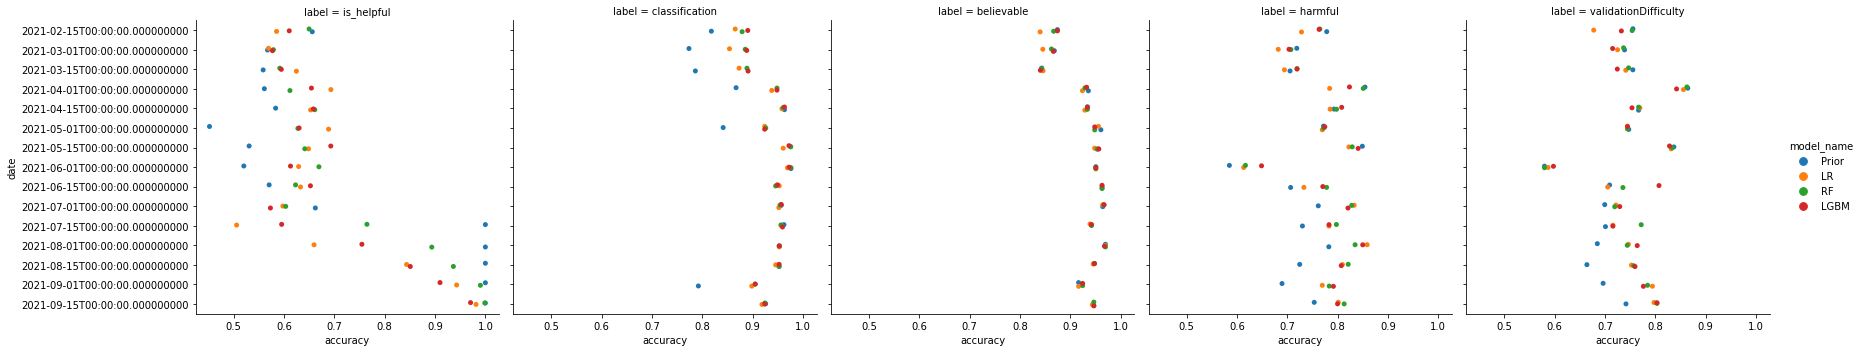

In [ ]:
sns.catplot(
    data=results_df, y="date", x="accuracy",
    col='label', hue='model_name',legend=True)
# plt.xticks(rotation=45)
# plt.title('Model Accuracy Over Time')
plt.show()

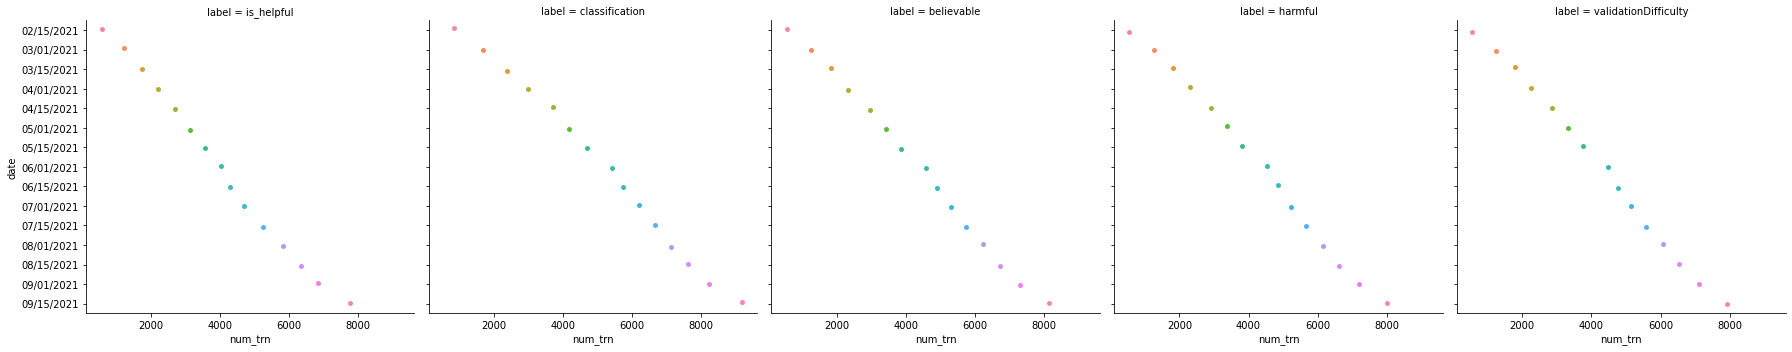

In [ ]:
sns.catplot(
    data=tasks_df, y="date", x="num_trn",
    col='label' ,legend=True)
plt.show()

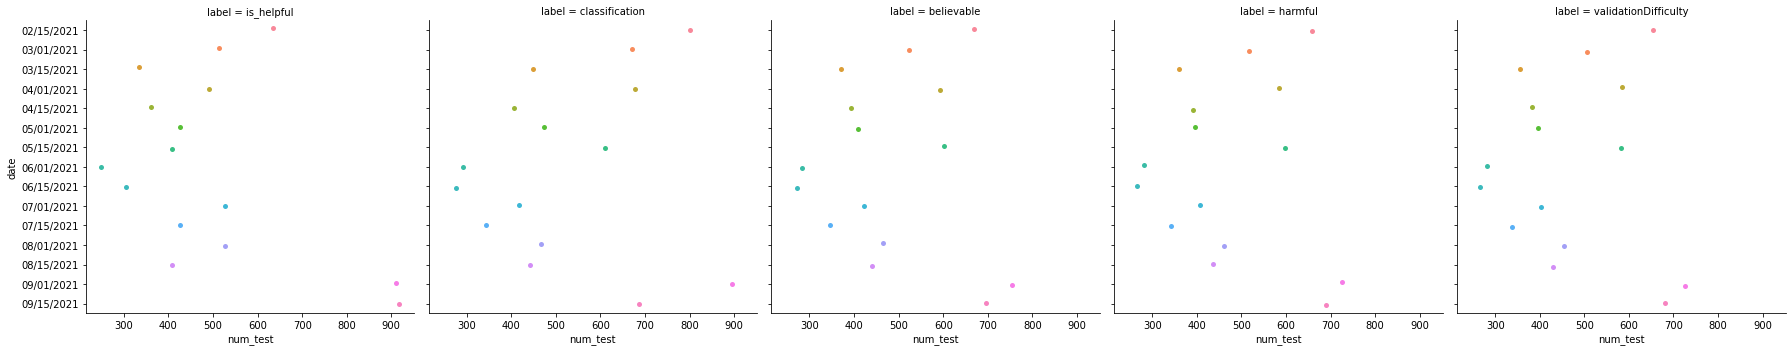

In [ ]:
sns.catplot(
    data=tasks_df, y="date", x="num_test",
    col='label' ,legend=True)
plt.show()

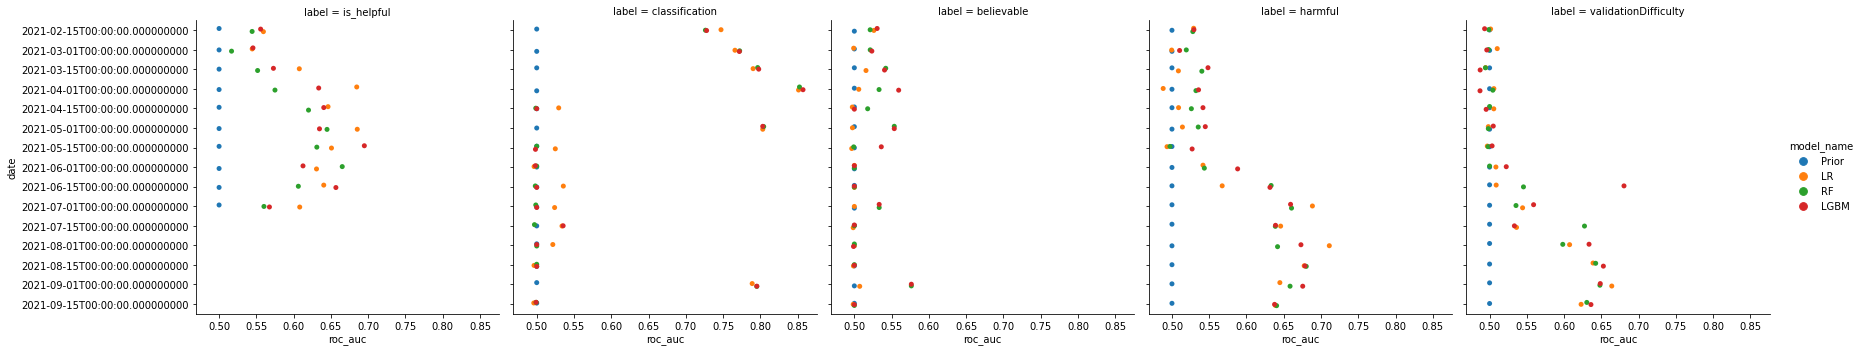

In [ ]:
sns.catplot(
    data=results_df, y="date", x="roc_auc",
    col='label', hue='model_name',legend=True)

## Pickle Output for Storage

In [ ]:
o = {}
o['results_df'] = results_df
o['tasks_df'] = tasks_df

with open('predicted.pickle', 'wb') as handle:
    pickle.dump(o, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# possible_labels = ['classification', 'believable', 'harmful', 'validationDifficulty']

# def predict_tweets(
#     X_tweets_mat, y_tweets, test_size=0.25, random_state=0, labels=possible_labels
# ): 
#     ret = {}
#     for label in labels:
#         y_tweets_mat = y_tweets.loc[:, label]

#         X_tweets_m = X_tweets_mat[y_tweets[label] != 'UNCLEAR']
#         y_tweets_m = y_tweets[y_tweets[label] != 'UNCLEAR'][label].astype('int')

#         X_tweets_train, X_tweets_test, y_tweets_train, y_tweets_test = train_test_split(X_tweets_m, y_tweets_m, test_size=test_size, random_state=random_state)        

#         pipeline_lr = Pipeline([('scalar1',StandardScaler()), ('lr_classifier', LogisticRegression(random_state=random_state))])
#         pipeline_dt = Pipeline([('scalar2',StandardScaler()), ('dt_classifier', DecisionTreeClassifier(random_state=random_state))])
#         pipeline_rf = Pipeline([('rf_classifier', RandomForestClassifier(random_state=random_state))])

#         pipeline_gs = Pipeline([('scalar4',StandardScaler()), ('gs_classifier', GaussianNB())])
#         pipelines = [
#             pipeline_lr, 
#             pipeline_rf, 
#             #pipeline_dt, 
#             #pipeline_gs
#         ]

#         best_acc = 0.0
#         best_classifier = ''
#         best_improvement = 0

#         pipe_dict = {0: 'Logistic Regression', 1 : "Random Forest", 2: "Tree", 3: "Gaussian"}

#         for pipe in pipelines:
#             pipe.fit(X_tweets_train, y_tweets_train)

        
#         # if y_tweets_train.mean() < 0.5:
#         #     print("Guess Most Frequent Label ", 1- y_tweets_train.mean(), 1- y_tweets_test.mean())
#         # else:
#         #     print("Guess Most Frequent Label ", y_tweets_train.mean(), y_tweets_test.mean())
#         print("=====")
#         print(label)
#         baseline = max(1-y_tweets_test.mean(), y_tweets_test.mean())
#         print("Guess Most Frequent Label on test", baseline)
        
#         for i, model in enumerate(pipelines):
#             acc = model.score(X_tweets_test, y_tweets_test)
#             improvement = acc - baseline
#             print("{} Test Accuracy: {}, +{}".format(pipe_dict[i], acc, improvement))

#             best_improvement = max(best_improvement, improvement)
#             best_acc = max(best_acc, acc)
#             best_classifier = pipe_dict[i]

#         print(best_classifier, best_acc, best_improvement)
#         ret[label] = {
#             'best_classifier': best_classifier,
#             'best_improvement': best_improvement * 100,
#             'best_acc': best_acc * 100
#         }
#     return ret
# def predict_notes(X_notes_mat, y_notes_mat, test_size=0.25, random_state=0):    
#     X_notes_train, X_notes_test, y_notes_train, y_notes_test = train_test_split(X_notes_mat, y_notes_mat, test_size=test_size, random_state=random_state)
    
#     pipeline_lr = Pipeline([('scalar1',StandardScaler()), ('lr_classifier', LogisticRegression(random_state=random_state))])
#     #pipeline_dt = Pipeline([('scalar2',StandardScaler()), ('dt_classifier', DecisionTreeClassifier(random_state=random_state))])
#     pipeline_rf = Pipeline([('rf_classifier', RandomForestClassifier(random_state=random_state))])

#     # pipeline_gs = Pipeline([('scalar4',StandardScaler()), ('gs_classifier', GaussianNB())])
#     pipelines = [
#         pipeline_lr, 
#         pipeline_rf, 
#         #pipeline_dt, 
        
#        # pipeline_gs
#     ]

#     best_acc = 0
#     best_classifier = ''
#     best_improvement = 0

#     pipe_dict = {0: 'Logistic Regression', 1 : "Random Forest", 2: "Tree", 3: "Gaussian"}

#     for pipe in pipelines:
#         pipe.fit(X_notes_train, y_notes_train)

#     print("=====")
#     print("Predicting 'Is note helpful?'")
#     baseline = max(1-y_notes_test.mean(), y_notes_test.mean())
#     print("Guess Mode:", baseline)
#     for i, model in enumerate(pipelines):
#         acc = model.score(X_notes_test, y_notes_test)
#         improvement = acc - baseline
#         print("{} Test Accuracy: {}, +{}".format(pipe_dict[i], acc, improvement))
#         if improvement > best_improvement:
#             best_classifier = pipe_dict[i]
#         best_improvement = max(best_improvement, improvement)
#         best_acc = max(best_acc, acc)
#         print()

#     print(best_classifier, best_acc, best_improvement)
#     return {
#         'best_classifier': best_classifier,
#         'best_improvement': best_improvement * 100,
#         'best_acc': acc * 100,
#     }

In [ ]:
# v_diff_results_df = pd.DataFrame([x['validationDifficulty'] for x in tweets_improvements])
# v_diff_results_df['Time'] = dates
# sns.lineplot(x="Time", y="best_improvement", data=v_diff_results_df)
# plt.xticks(rotation=45)
# plt.title('Model Improvement Over Time - validation difficulty')
# plt.show()

In [ ]:
# def preprocess_tweets_with_notes(tweets_with_notes, metadata=True, trn_mask=None):
#     """
#     Take in the tweets data as provided by twitter and output
#     a "ready for ML" version.

#     Args - meant to match the output of the consolidate_files() function
#         tweetsWithNotes - pandas dataframe joining tweets and their corresponding notes
#         metadata - boolean for whether or not to include additional information about the text

#     Output
#         X_tweets_mat - numpy array containing the vectorized version of text data and optionally 
#                        optionally the corresponding metadata
#         y_tweets - pandas dataframe containing the various y predictors of the tweets data
#     """

#     # vectorize text content and add metadata if specified
#     if metadata:
#         docs = nlp.pipe(tweets_with_notes['clean_text_as_str'])
#         X_tweet_vector = np.array([x.vector for x in docs])
#         X_tweets_mat = np.concatenate(
#             [X_tweet_vector, tweets_with_notes[metadata_cols].to_numpy()],
#             axis=1
#         )
#     else:
#         docs = nlp.pipe(tweets_with_notes['clean_text_as_str'])
#         X_tweet_vector = np.array([x.vector for x in docs])
#         X_tweets_mat = pd.DataFrame(X_tweet_vector.tolist(), columns = 'vector').values

#     y_tweets = tweets_with_notes[['classification', 'believable', 'harmful', 'validationDifficulty']]

#     cleanup = {
#         "classification": {
#             "MISINFORMED_OR_POTENTIALLY_MISLEADING": 1, "NOT_MISLEADING": 0
#             },
#         "believable": {"BELIEVABLE_BY_MANY": 1, "BELIEVABLE_BY_FEW": 0},
#         "harmful": {"CONSIDERABLE_HARM": 1, "LITTLE_HARM": 0},
#         "validationDifficulty": {"EASY": 0, "CHALLENGING": 1}
#     }
#     y_tweets = y_tweets.astype(str).replace(cleanup)
    
#     return X_tweets_mat, y_tweets_df

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c0e62a2c-7f45-414e-8164-5bf51e09d482' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>